# Data wrangling and functions for [tailoredpath.com/transition.html](https://tailoredpath.com/transition.html)
***


# Table of contents:

1. [Import libraries and load files](#1)
2. [Data wrangling](#2)
3. [Comparison functions](#3)
    1. [Education](#3A)
        1. [Functions](#3Aa)
        2. [Visualization with Matplotlib](#3Ab)
        3. [Prepare data for visualization with Chart.js](#3Ac)
    2. [Experience](#3B)
        1. [Functions](#3Ba)
    3. [Skills](#3C)
        1. [Functions](#3Ca)
        2. [Visualization with Matplotlib](#3Cb)
        3. [Prepare data for visualization with Chart.js](#3Cc)  
    4. [Knowledge](#3D)
        1. [Functions](#3Da)
        2. [Visualization with Matplotlib](#3Db)
        3. [Prepare data for visualization with Chart.js](#3Dc)
    5. [Estimated transition difficulty](#3E)
    5. [Generate & export Json](#3F)
    
    
# Purpose of this notebook:

This notebook contains the baseline for the Python script that runs on the **[interactive web app: tailoredpath.com/transition](https://tailoredpath.com/transition.html)**. 

The app accesses the data via an API built with [Python Flask](http://flask.pocoo.org/). The charts were developped with [Chart.js](https://www.chartjs.org/).

This notebook reproduces these visualizations with matplotlib.


# Data:

The [ONET program](https://www.onetcenter.org/overview.html) is the primary source of occupational information in the US. 

For each job, ONET rates the importance and level of all skills, knowledge and abilities, along with the required levels of education and experience. This data is available on their [resource center](https://www.onetcenter.org/database.html#individual-files).

More specifically, this notebook uses the following datasets:
- [Knowledge.xlsx](https://www.onetcenter.org/dictionary/23.3/excel/knowledge.html)
- [Skills.xlsx](https://www.onetcenter.org/dictionary/23.3/excel/skills.html)
- [Education, Training, and Experience.xlsx](https://www.onetcenter.org/dictionary/23.3/excel/education_training_experience.html)
- [Education, Training, and Experience Categories.xlsx](https://www.onetcenter.org/dictionary/23.3/excel/ete_categories.html)
- [Job Zones.xlsx](https://www.onetcenter.org/dictionary/23.3/excel/job_zones.html)

# 1. Import libraries and load files <a name="1"></a>

In [1]:
# Import libraries

import pandas as pd
pd.set_option("display.max_columns", 101)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Load files

skills = pd.read_excel('../../../../Documents/tailoredpath/databases/ONET/Skills.xlsx')
knowledge = pd.read_excel('../../../../Documents/tailoredpath/databases/ONET/Knowledge.xlsx')
education_experience = pd.read_excel('../../../../Documents/tailoredpath/databases/ONET/Education, Training, and Experience.xlsx')
job_zones = pd.read_excel('../../../../Documents/tailoredpath/databases/ONET/Job Zones.xlsx')
e_categories = pd.read_excel('../../../../Documents/tailoredpath/databases/ONET/Education, Training, and Experience Categories.xlsx')

# 2. Data wrangling <a name="2"></a>

In [4]:
# Filter job zones

jobzone345 = job_zones[job_zones['Job Zone'].isin([3,4,5])]['O*NET-SOC Code'].tolist()

def filter_job_zones(df):
    return df[df['O*NET-SOC Code'].isin(jobzone345)]

In [5]:
skills = filter_job_zones(skills)
knowledge = filter_job_zones(knowledge)
education_experience = filter_job_zones(education_experience)

In [6]:
# Filter columns

# Columns to keep for skills & knowledge

cols_to_keep = [
    'O*NET-SOC Code', 
    'Title', 
    'Element Name', 
    'Scale ID',
    'Data Value'
]

# Columns to keep for education_experience

cols_to_keep_ee = [
    'O*NET-SOC Code', 
    'Title', 
    'Scale ID',
    'Category',
    'Data Value'
]

def filter_columns(df, lc):
    return df[lc].copy()

In [7]:
skills = filter_columns(skills, cols_to_keep)
knowledge = filter_columns(knowledge, cols_to_keep)
education_experience = filter_columns(education_experience, cols_to_keep_ee)

In [8]:
# Create education DF

education = education_experience[education_experience['Scale ID'] == 'RL']
education = education[education['Category'].isin([5,6,7,8,9,10,11,12])] #Filtered only Associate, Bachelor, Master and Doctoral degrees and other certificates (7,9,10)

In [9]:
# Create experience DF

experience = education_experience[education_experience['Scale ID'] == 'RW']

#### Default jobs to test comparison

In [10]:
job1 = "Executive Secretaries and Executive Administrative Assistants"

In [11]:
job2 = "Human Resources Managers"

# 3. Comparison functions <a name="3"></a>

## 3.A. Education <a name="3A"></a>

### 3.A.a. Functions <a name="3Aa"></a>

In [12]:
def get_job_ed_stats(job):
    job_ed = education[education['Title'] == job]
    
    job_5 = job_ed.loc[job_ed['Category'] == 5, 'Data Value'].sum() #select value
    job_5_to100 = job_5 *100/(job_ed['Data Value'].sum()) #bring to 100 scale in case all values aren't included for this job

    job_6 = job_ed.loc[job_ed['Category'].isin([6,7]), 'Data Value'].sum()
    job_6_to100 = job_6 *100/(job_ed['Data Value'].sum())

    job_8 = job_ed.loc[job_ed['Category'].isin([8,9,10]), 'Data Value'].sum()
    job_8_to100 = job_8 *100/(job_ed['Data Value'].sum())

    job_11 = job_ed.loc[job_ed['Category'].isin([11,12]), 'Data Value'].sum()
    job_11_to100 = job_11 *100/(job_ed['Data Value'].sum())
        
    return pd.Series([job_5_to100, job_6_to100, job_8_to100, job_11_to100], index=["Associate", "Bachelor", "Master", "Doctorate"])
    

In [42]:
def compare_ed(job1, job2):
    
    job1_stats_lst = get_job_ed_stats(job1).tolist()
    job2_stats_lst = get_job_ed_stats(job2).tolist()
    idx_max_job1 = np.argmax(job1_stats_lst)
    idx_max_job2 = np.argmax(job2_stats_lst)
    
    if idx_max_job2 > idx_max_job1:
        level = 2

    elif idx_max_job2 == idx_max_job1:
        level = 1

    else:
        level = 0
        
    return level

def ed_info(job):
    label_max_job = get_job_ed_stats(job).idxmax().lower()
    if label_max_job == 'none':
        to_print = "In general, {} do not hold a college degree.".format(job)
    elif label_max_job.startswith('a'):
        to_print = "In general, {} hold an {} degree.".format(job, label_max_job)
    else:
        to_print = "In general, {} hold a {} degree.".format(job, label_max_job)
    return to_print

In [43]:
# 2 is higher, 1 is similar, 0 is lower
compare_ed(job1, job2)

2

In [44]:
ed_info(job2)

'In general, Human Resources Managers hold a bachelor degree.'

### 3.A.b. Visualization with Matplotlib <a name="3Ab"></a>

In [118]:
def show_radar_ed(job1, job2):

    # Data
    labels = get_job_ed_stats(job1).index
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    angles=np.concatenate((angles,[angles[0]]))
    
    stats_1 = get_job_ed_stats(job1).tolist()
    stats_2 = get_job_ed_stats(job2).tolist()
    
    stats_1=np.concatenate((stats_1,[stats_1[0]]))
    stats_2=np.concatenate((stats_2,[stats_2[0]]))
    
    # Figure
    fig = plt.figure(figsize=(6,6), dpi= 80)
    
    # Colors
    colors=['#81c784', '#42a5f5']
    
    # Plot
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats_1, color=colors[0], linewidth=2)
    ax.plot(angles, stats_2, color=colors[1], linewidth=2)
    ax.fill(angles, stats_1, color=colors[0], alpha=0.25)
    ax.fill(angles, stats_2, color=colors[1], alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(job1)
    ax.grid(True)
    
    # Title
    plt.title("From {} to {}".format(job1, job2), fontsize=15)
    # Legend
    plt.legend({group:col for group, col in zip([job1, job2], colors)})
    
    plt.show()

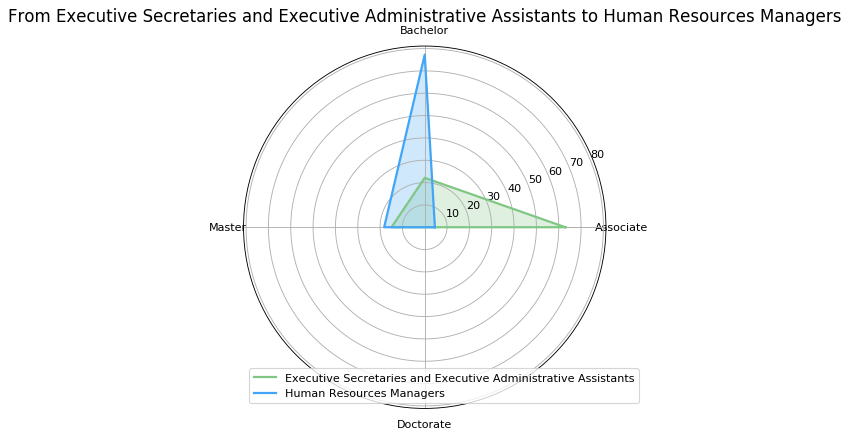

In [119]:
show_radar_ed(job1, job2)

### 3.A.c. Prepare data for visualization with Chart.js <a name="3Ac"></a>

#### radar_src

In [16]:
get_job_ed_stats(job1).tolist()

[62.98023125699367, 22.1372622155912, 14.882506527415144, 0.0]

#### radar_tgt

In [17]:
get_job_ed_stats(job2).tolist()

[4.55, 77.27000000000001, 18.18, 0.0]

## 3.B. Experience <a name="3B"></a>

### 3.B.a. Functions <a name="3Ba"></a>

In [18]:
def get_job_exp_stats(job):
    
    job_exp = experience[experience['Title'] == job]
    
    exp_categories = e_categories.loc[e_categories["Scale ID"] == "RW", "Category Description"]
    
    return pd.Series(data = job_exp["Data Value"].tolist(), index = exp_categories.tolist())

In [45]:
def compare_exp(job1, job2):
    
    job1_stats_lst = get_job_exp_stats(job1).tolist()
    job2_stats_lst = get_job_exp_stats(job2).tolist()
    idx_max_job1 = np.argmax(job1_stats_lst)
    idx_max_job2 = np.argmax(job2_stats_lst)
    
    if idx_max_job2 > idx_max_job1:
        level = 2

    elif idx_max_job2 == idx_max_job1:
        level = 1
        
    else:
        level = 0

    return level

def exp_info(job):
    label_max_job = get_job_exp_stats(job).idxmax().lower()
    if label_max_job == 'none':
        to_print = "In general, {} do not have any prior experience.".format(job)
    else:
        to_print = "In general, {} have {} of experience.".format(job, label_max_job)
    return to_print

In [46]:
# 2 is higher, 1 is similar, 0 is lower
compare_exp(job1, job2)

2

In [47]:
exp_info(job2)

'In general, Human Resources Managers have over 4 years, up to and including 6 years of experience.'

## 3.C. Skills <a name="3C"></a>

### 3.C.a. Functions <a name="3Ca"></a>

In [22]:
def get_skills(job):
    return skills[skills["Title"] == job] 

def get_skills_im(job):
    job_skills = get_skills(job)
    return job_skills.loc[job_skills["Scale ID"] == "IM"].sort_values(by = "Data Value", ascending = False).head(10)["Element Name"].tolist()

def get_skills_lv(job1, job2):

    job1_skills = get_skills(job1)
    job2_skills = get_skills(job2)
    
    skills_im = get_skills_im(job2)
    
    job1_skills_lv = []
    job2_skills_lv = []
    gap_skills_lv = []

    for s in skills_im:
        dv1 = job1_skills.loc[(job1_skills["Scale ID"] == "LV") & (job1_skills["Element Name"] == s),"Data Value"].iloc[0]
        dv2 = job2_skills.loc[(job2_skills["Scale ID"] == "LV") & (job2_skills["Element Name"] == s),"Data Value"].iloc[0]
        job1_skills_lv.append(dv1)
        job2_skills_lv.append(dv2)
        comp = dv2 - dv1
        gap_skills_lv.append(comp)
        
    return pd.DataFrame(data = {job1: job1_skills_lv, job2: job2_skills_lv, "Gap": gap_skills_lv}, index = skills_im, columns = [job1, job2, "Gap"])


### 3.C.b. Visualization with Matplotlib <a name="3Cb"></a>

In [138]:
def show_bar_skills(job1, job2):
    
    # Data
    labels_skills = get_skills_lv(job1, job2).index.tolist()
    data_1_skills = get_skills_lv(job1, job2).iloc[:,0].tolist()
    data_2_skills = get_skills_lv(job1, job2).iloc[:,1].tolist()
    
    n_skills = len(labels_skills)
    
    # Figure
    plt.figure(figsize=(8,6), dpi= 80)
    
    # Colors
    colors=['#81c784', '#42a5f5']
    
    # Plot
    y = np.arange(n_skills)
    plt.barh(y, width= data_2_skills[::-1], color=colors[0])
    plt.barh(y, width= data_1_skills[::-1], color=colors[1])

    
    # Style
    plt.yticks(ticks=range(n_skills), labels=labels_skills)
    # Title
    plt.title("From {} to {}".format(job1, job2), fontsize=15)
    # Legend
    plt.legend({group:col for group, col in zip(['Gap', 'Current'], colors)}, loc='upper right')
    # Spines 
    plt.gca().spines["top"].set_alpha(.3)
    plt.gca().spines["bottom"].set_alpha(.3)
    plt.gca().spines["right"].set_alpha(.3)
    plt.gca().spines["left"].set_alpha(.3)

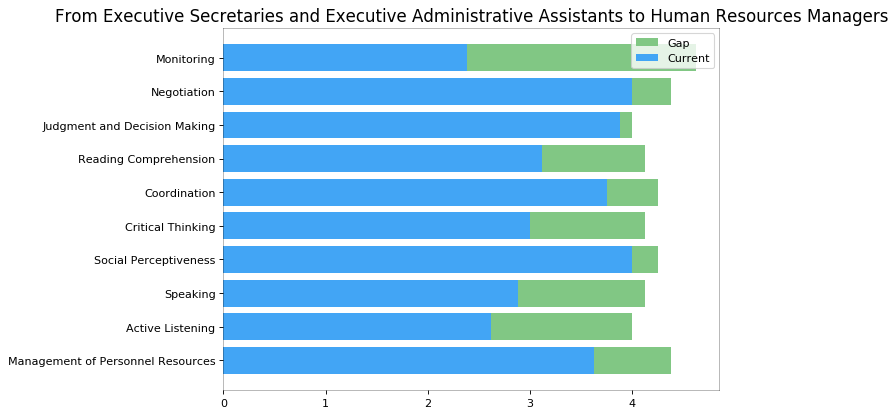

In [139]:
show_bar_skills(job1, job2)

### 3.C.c. Prepare data for visualization with Chart.js <a name="3Cc"></a>

#### bar1_lbl

In [23]:
get_skills_lv(job1, job2).index.tolist()

['Management of Personnel Resources',
 'Active Listening',
 'Speaking',
 'Social Perceptiveness',
 'Critical Thinking',
 'Coordination',
 'Reading Comprehension',
 'Judgment and Decision Making',
 'Negotiation',
 'Monitoring']

#### bar1_src

In [24]:
get_skills_lv(job1, job2).iloc[:,0].tolist()

[2.38, 4.0, 3.88, 3.12, 3.75, 3.0, 4.0, 2.88, 2.62, 3.62]

#### bar1_tgt

In [25]:
get_skills_lv(job1, job2).iloc[:,-1].tolist()

[2.24,
 0.3799999999999999,
 0.1200000000000001,
 1.0,
 0.5,
 1.12,
 0.25,
 1.2400000000000002,
 1.38,
 0.7599999999999998]

## 3.D. Knowledge <a name="3D"></a>

### 3.D.a. Functions <a name="3Da"></a>

In [26]:
def get_know(job):
    return knowledge[knowledge["Title"] == job]  

def get_know_im(job):
    job_know = get_know(job)
    return job_know.loc[job_know["Scale ID"] == "IM"].sort_values(by = "Data Value", ascending = False).head(10)["Element Name"].tolist()

def get_know_lv(job1, job2):

    job1_know = get_know(job1)
    job2_know = get_know(job2)
    
    know_im = get_know_im(job2)
    
    job1_know_lv = []
    job2_know_lv = []
    gap_know_lv = []

    for s in know_im:
        dv1 = job1_know.loc[(job1_know["Scale ID"] == "LV") & (job1_know["Element Name"] == s),"Data Value"].iloc[0]
        dv2 = job2_know.loc[(job2_know["Scale ID"] == "LV") & (job2_know["Element Name"] == s),"Data Value"].iloc[0]
        job1_know_lv.append(dv1)
        job2_know_lv.append(dv2)
        comp = dv2 - dv1
        gap_know_lv.append(comp)
        
    return pd.DataFrame(data = {job1: job1_know_lv, job2: job2_know_lv, "Gap": gap_know_lv}, index = know_im, columns = [job1, job2, "Gap"])


### 3.D.b. Visualization with Matplotlib <a name="3Db"></a>

In [140]:
def show_bar_know(job1, job2):
    
    # Data
    labels_know = list(get_know_lv(job1, job2).index)
    data_1_know = get_know_lv(job1, job2).iloc[:,0].tolist()
    data_2_know = get_know_lv(job1, job2).iloc[:,1].tolist()
    
    n_know = len(labels_know)
    
    # Figure
    plt.figure(figsize=(6,6), dpi= 80)
    
    # Colors
    colors=['#81c784', '#42a5f5']
    
    # Plot
    y = np.arange(n_know)
    plt.barh(y, width= data_2_know[::-1], color=colors[0])
    plt.barh(y, width= data_1_know[::-1], color=colors[1])
    
    # Style
    plt.yticks(ticks=range(n_know), labels=labels_know)
    # Title
    plt.title("From {} to {}".format(job1, job2), fontsize=15)
    # Legend
    plt.legend({group:col for group, col in zip(['Gap', 'Current'], colors)}, loc='upper right')
    # Spines 
    plt.gca().spines["top"].set_alpha(.3)
    plt.gca().spines["bottom"].set_alpha(.3)
    plt.gca().spines["right"].set_alpha(.3)
    plt.gca().spines["left"].set_alpha(.3)

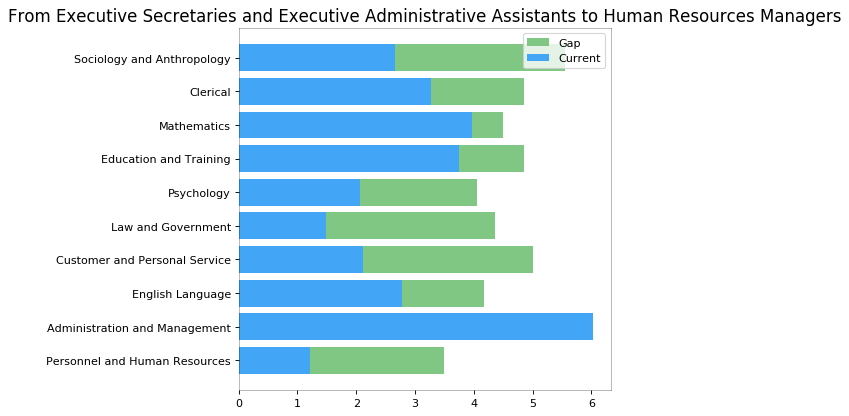

In [141]:
show_bar_know(job1, job2)

### 3.D.c. Prepare data for visualization with Chart.js <a name="3Dc"></a>

#### bar2_lbl

In [27]:
get_know_lv(job1, job2).index.tolist()

['Personnel and Human Resources',
 'Administration and Management',
 'English Language',
 'Customer and Personal Service',
 'Law and Government',
 'Psychology',
 'Education and Training',
 'Mathematics',
 'Clerical',
 'Sociology and Anthropology']

#### bar2_src

In [28]:
get_know_lv(job1, job2).iloc[:,0].tolist()

[2.66, 3.28, 3.97, 3.75, 2.07, 1.49, 2.11, 2.78, 6.03, 1.21]

#### bar2_tgt

In [29]:
get_know_lv(job1, job2).iloc[:,-1].tolist()

[2.8899999999999997,
 1.5800000000000005,
 0.5299999999999998,
 1.1100000000000003,
 1.98,
 2.87,
 2.89,
 1.4,
 -1.2700000000000005,
 2.29]

## 3.E. Estimated transition difficulty  <a name="3E"></a>

In [30]:
def gap(job1, job2):
    skills_gap = get_skills_lv(job1, job2).iloc[:,-1].sum()
    knowledge_gap = get_know_lv(job1, job2).iloc[:,-1].sum()
    total = skills_gap + knowledge_gap
    
    if total < 10:
        difficulty = 0
    elif total < 30:
        difficulty = 1
    else:
        difficulty = 2
    
    return difficulty

In [31]:
# 0 is low, 1 is medium, 2 is high
gap(job1, job2)

1

## 3.F. Generate & export Json  <a name="3F"></a>

In [32]:
def gen_json(job1, job2):
    result = {"source_job_name": job1,
              "target_job_name" : job2,
              "transition_gen" : gap(job1, job2),
              "education_level": compare_ed(job1, job2),
              "education_comp" : ed_info(job2),
              "radar_src" : get_job_ed_stats(job1).tolist(),
              "radar_tgt" : get_job_ed_stats(job2).tolist(),
              "experience_level" : compare_exp(job1, job2),
              "experience_comp" : exp_info(job2),
              "bar1_lbl" : get_skills_lv(job1, job2).index.tolist(),
              "bar1_src" : get_skills_lv(job1, job2).iloc[:,0].tolist(),
              "bar1_tgt" : get_skills_lv(job1, job2).iloc[:,-1].tolist(),
              "bar2_lbl" : get_know_lv(job1, job2).index.tolist(),
              "bar2_src" : get_know_lv(job1, job2).iloc[:,0].tolist(),
              "bar2_tgt" : get_know_lv(job1, job2).iloc[:,-1].tolist()
             }
    
    return result

In [33]:
import json

In [34]:
result = gen_json(job1, job2)

In [35]:
print(json.dumps(result, indent=4))

{
    "source_job_name": "Executive Secretaries and Executive Administrative Assistants",
    "target_job_name": "Human Resources Managers",
    "transition_gen": 1,
    "education_level": 2,
    "education_comp": "In general, Human Resources Managers hold a Bachelor degree.",
    "radar_src": [
        62.98023125699367,
        22.1372622155912,
        14.882506527415144,
        0.0
    ],
    "radar_tgt": [
        4.55,
        77.27000000000001,
        18.18,
        0.0
    ],
    "experience_level": 2,
    "experience_comp": "In general, Human Resources Managers have Over 4 years, up to and including 6 years of experience.",
    "bar1_lbl": [
        "Management of Personnel Resources",
        "Active Listening",
        "Speaking",
        "Social Perceptiveness",
        "Critical Thinking",
        "Coordination",
        "Reading Comprehension",
        "Judgment and Decision Making",
        "Negotiation",
        "Monitoring"
    ],
    "bar1_src": [
        2.38,
    

{
  "source_job_name": "Executive Secretaries and Executive Administrative Assistants",
  "target_job_name": "Human Resources Managers",
  "transition_gen": 1,
  "education_level": 2,
  "education_comp": "In general, Human Resources Managers hold at least a Bachelor degree.",
  "radar_src": [62.98023125699367, 22.1372622155912, 14.882506527415144, 0.0],
  "radar_tgt": [4.55, 77.27000000000001, 18.18, 0.0],
  "experience_level": 2,
  "experience_comp": "In general, Human Resources Managers have at least Over 4 years, up to and including 6 years of experience.",
  "bar1_lbl":["Management of Personnel Resources",
 "Active Listening",
 "Speaking",
 "Social Perceptiveness",
 "Critical Thinking",
 "Coordination",
 "Reading Comprehension",
 "Judgment and Decision Making",
 "Negotiation",
 "Monitoring"],
  "bar1_src":[2.38, 4.0, 3.88, 3.12, 3.75, 3.0, 4.0, 2.88, 2.62, 3.62],
  "bar1_tgt": [2.24, 0.3799999999999999, 0.1200000000000001, 1.0, 0.5, 1.12, 0.25, 1.2400000000000002, 1.38, 0.7599999999999998],
  "bar2_lbl": ["Personnel and Human Resources", "Administration and Management", "English Language", "Customer and Personal Service", "Law and Government", "Psychology", "Education and Training", "Mathematics", "Clerical", "Sociology and Anthropology"],
  "bar2_src":[2.66, 3.28, 3.97, 3.75, 2.07, 1.49, 2.11, 2.78, 6.03, 1.21],
  "bar2_tgt": [2.8899999999999997, 1.5800000000000005, 0.5299999999999998, 1.1100000000000003, 1.98, 2.87, 2.89, 1.4, -1.2700000000000005, 2.29]
}